In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import pyabc

import healpy as hp
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import pandas as pd

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import dipole
from abc_free_dipole import model, distance
import generate_mocks as gm
import multipoles

### results

In [3]:
resdir = '/scratch/aew492/lss-dipoles_results/results/ABC/fake_data/free_dipole'
nside = 64

In [6]:
def case_dir(distance_nside, dipamp, log_excess, base_rate, selfunc_str, tag=''):
    return os.path.join(resdir, f'nside{distance_nside}_dipole-{dipamp:.4f}_excess-1e{log_excess}_base-rate-{base_rate:.4f}_{selfunc_str}{tag}')

### fake Quaia, nside=1: expected (i.e. kinematic only) dipole, 1e-6 excess power, no shot noise, no selection effects

In [30]:
distance_nside = 1
input_dipamp = 0.0052
input_log_excess = -6.0
base_rate = 33.6330
selfunc_str = 'ones'

nmocks = 500
ngens = 10

resdict = np.load(os.path.join(case_dir(distance_nside, input_dipamp, input_log_excess, base_rate, selfunc_str, '_no-SN'),
                               f'{nmocks}mocks_{ngens}gens_2025-03-05', 'results.npy'),
                  allow_pickle=True).item()
data = resdict['data']  # the data as raw quasar counts
data_pars = resdict['data_pars']
input_dipole_x, input_dipole_y, input_dipole_z = data_pars['dipole_x'], data_pars['dipole_y'], data_pars['dipole_z']
selfunc = resdict['selfunc']
observation = resdict['observation']  # the data as overdensity
history = resdict['history']  # History object
prior = resdict['prior']  # dictionary
posterior = resdict['posterior']  # pandas dataframe and weights associated with the final posterior
old_posteriors = resdict['old_posteriors']  # posteriors from the otehr generations

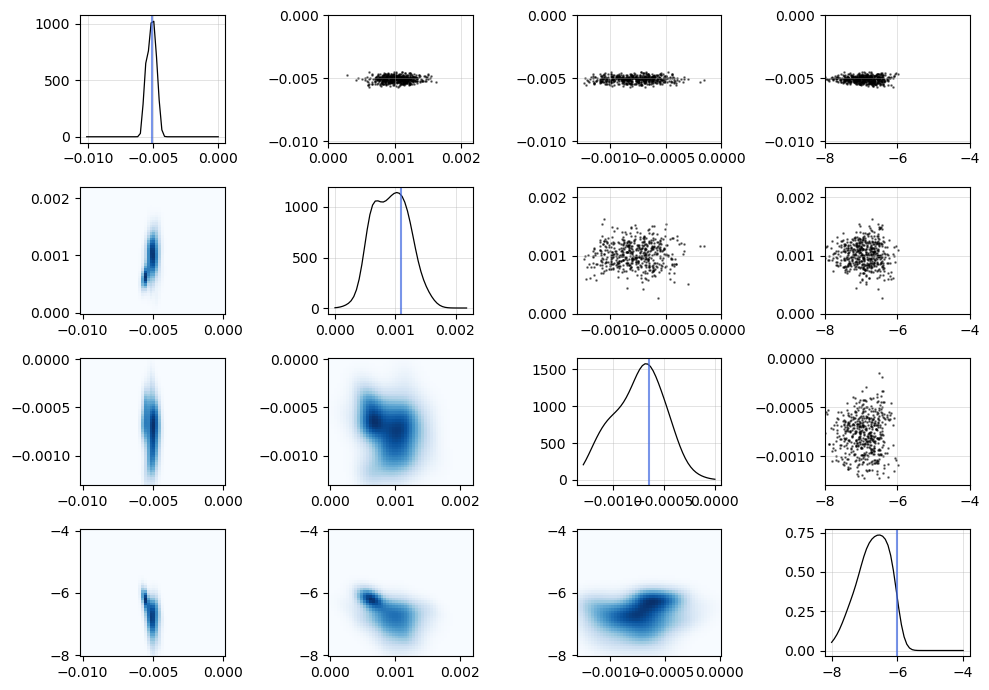

In [43]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,7), tight_layout=True)

for i, par_id in enumerate(par_ids):

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d(history, prior, par_id)
    ax.plot(x, pdf, c='k', alpha=1., lw=0.9)
    ax.grid(alpha=0.5, lw=0.5)
    ax.axvline(data_pars[par_id], c='royalblue', alpha=0.7)

    # axs[i,0].set_ylabel(par_id)
    # axs[len(par_ids)-1,i].set_xlabel(par_id)

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d(history, prior, par_ids[j], par_id)
        mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='Blues')

        # upper
        ax = axs[j, i]
        tools.scatter(history, prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
        ax.grid(alpha=0.5, lw=0.5)
    
# fig.suptitle(f'ABC posteriors, fake Quaia, nside={distance_nside}')

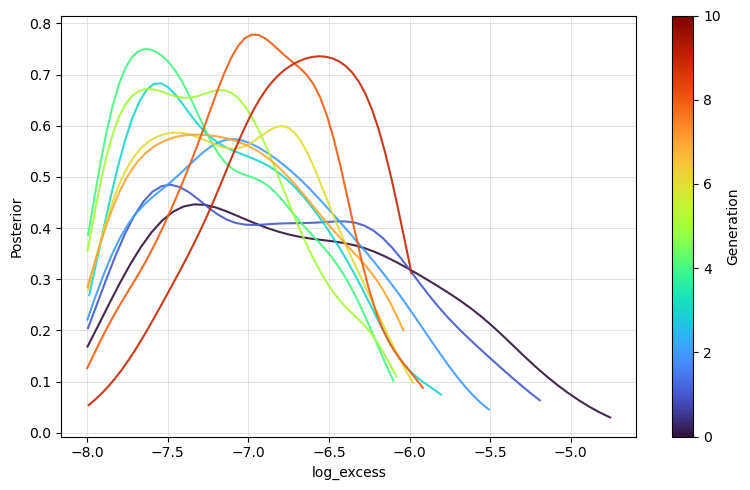

In [20]:
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
norm = mpl.colors.Normalize(vmin=0, vmax=history.max_t + 1)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
for i in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(history, "log_excess", t=i, ax=ax, color=smap.to_rgba(i), alpha=0.9)
ax.grid(alpha=0.5, lw=0.5)
fig.colorbar(smap, ax=ax, label='Generation')

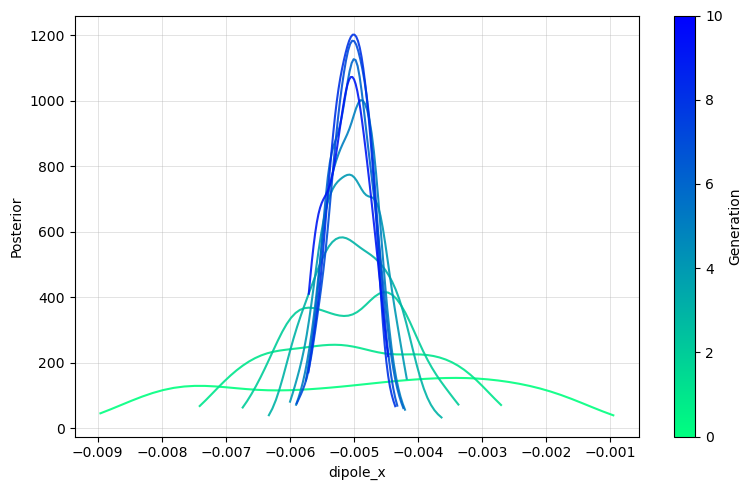

In [29]:
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
norm = mpl.colors.Normalize(vmin=0, vmax=history.max_t + 1)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='winter_r')
for i in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(history, "dipole_x", t=i, ax=ax, color=smap.to_rgba(i), alpha=0.9)
ax.grid(alpha=0.5, lw=0.5)
fig.colorbar(smap, ax=ax, label='Generation')

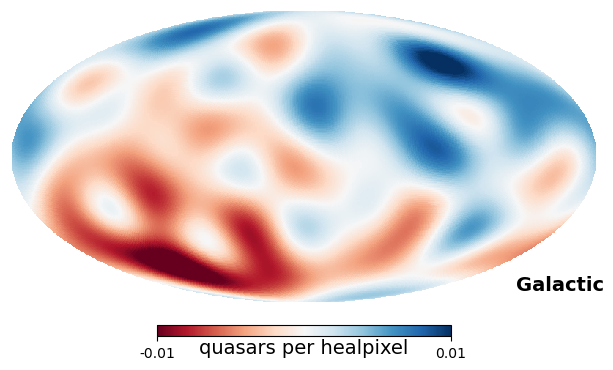

In [47]:
# input "observation"
fig = plt.figure(figsize=(12,4))
od_datamap = data['data'] / np.nanmean(data['data']) - 1
hp.mollview(od_datamap, coord=['C','G'], sub=(1,2,1), fig=fig, unit='quasars per healpixel', title='', min=-0.01, max=0.01, cmap='RdBu')

### fake Quaia, nside=2: expected (i.e. kinematic only) dipole, 1e-6 excess power, no shot noise, no selection effects

In [7]:
distance_nside = 2
input_dipamp = 0.0052
input_log_excess = -6.0
base_rate = 33.6330
selfunc_str = 'ones'

nmocks = 500
ngens = 10

resdict = np.load(os.path.join(case_dir(distance_nside, input_dipamp, input_log_excess, base_rate, selfunc_str, '_no-SN'),
                               f'{nmocks}mocks_{ngens}gens_2025-03-05', 'results.npy'),
                  allow_pickle=True).item()
data = resdict['data']  # the data as raw quasar counts
selfunc = resdict['selfunc']
observation = resdict['observation']  # the data as overdensity
history = resdict['history']  # History object
prior = resdict['prior']  # dictionary
posterior = resdict['posterior']  # pandas dataframe and weights associated with the final posterior
old_posteriors = resdict['old_posteriors']  # posteriors from the otehr generations

Text(0.5, 0.98, 'ABC posteriors, fake Quaia, nside=2')

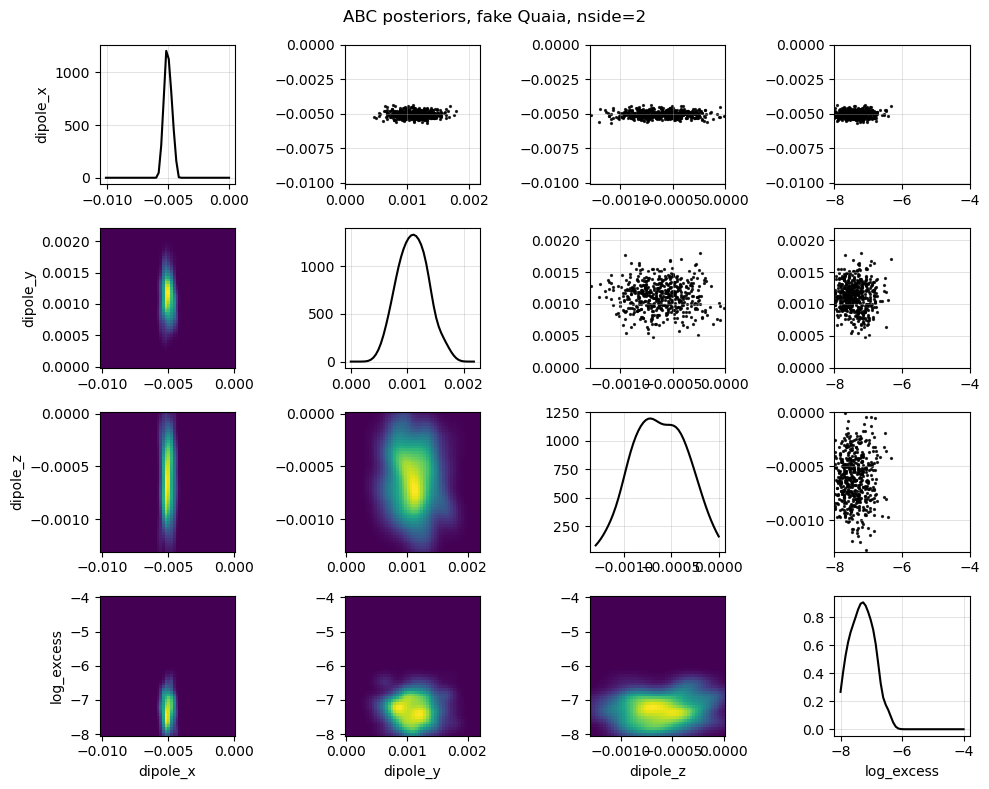

In [8]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,8), tight_layout=True)

for i, par_id in enumerate(par_ids):

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d(history, prior, par_id)
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(par_id)
    axs[len(par_ids)-1,i].set_xlabel(par_id)

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d(history, prior, par_ids[j], par_id)
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        tools.scatter(history, prior, par_id, par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
    
fig.suptitle(f'ABC posteriors, fake Quaia, nside={distance_nside}')

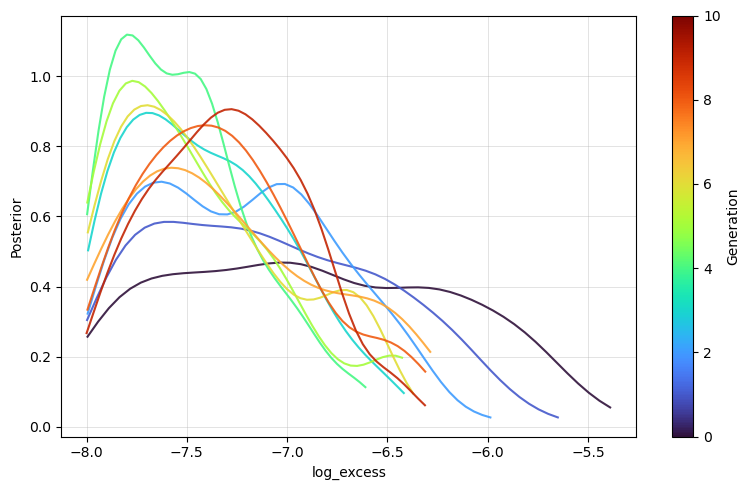

In [16]:
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
norm = mpl.colors.Normalize(vmin=0, vmax=history.max_t + 1)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
for i in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(history, "log_excess", t=i, ax=ax, color=smap.to_rgba(i), alpha=0.9)
ax.grid(alpha=0.5, lw=0.5)
fig.colorbar(smap, ax=ax, label='Generation')

### fake Quaia, nside=1: expected (i.e. kinematic only) dipole, 1e-6 excess power, shot noise, no selection effects

In [49]:
distance_nside = 1
input_dipamp = 0.0052
input_log_excess = -6.0
base_rate = 33.6330
selfunc_str = 'ones'

nmocks = 400
ngens = 10

resdict = np.load(os.path.join(case_dir(distance_nside, input_dipamp, input_log_excess, base_rate, selfunc_str),
                               f'{nmocks}mocks_{ngens}gens_2025-03-05', 'results.npy'),
                  allow_pickle=True).item()
data = resdict['data']  # the data as raw quasar counts
selfunc = resdict['selfunc']
observation = resdict['observation']  # the data as overdensity
history = resdict['history']  # History object
prior = resdict['prior']  # dictionary
posterior = resdict['posterior']  # pandas dataframe and weights associated with the final posterior
old_posteriors = resdict['old_posteriors']  # posteriors from the otehr generations

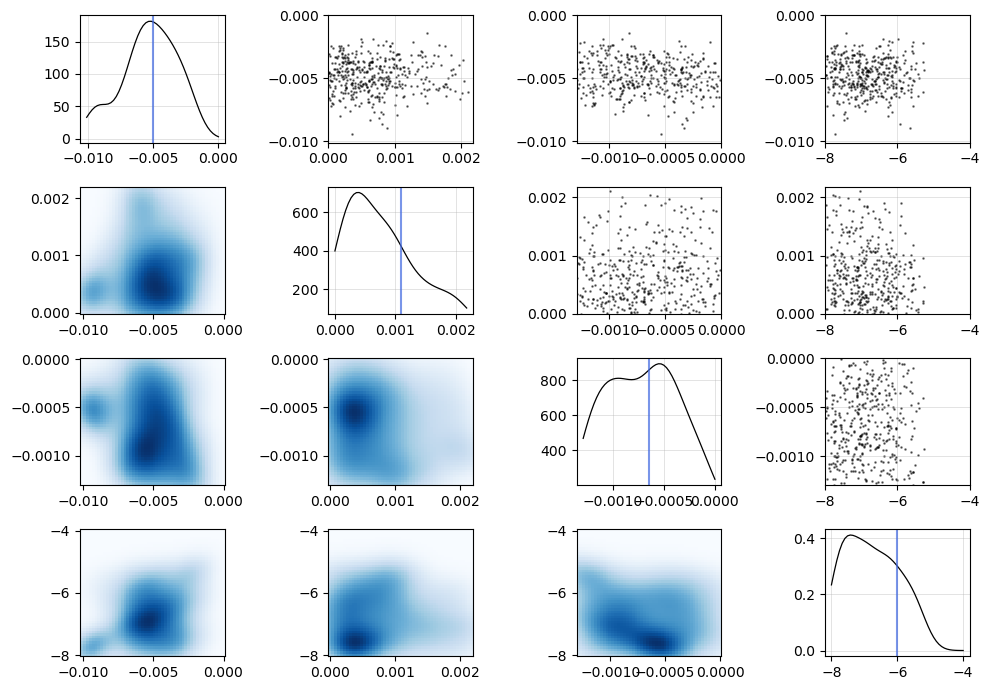

In [50]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,7), tight_layout=True)

for i, par_id in enumerate(par_ids):

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d(history, prior, par_id)
    ax.plot(x, pdf, c='k', alpha=1., lw=0.9)
    ax.grid(alpha=0.5, lw=0.5)
    ax.axvline(data_pars[par_id], c='royalblue', alpha=0.7)

    # axs[i,0].set_ylabel(par_id)
    # axs[len(par_ids)-1,i].set_xlabel(par_id)

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d(history, prior, par_ids[j], par_id)
        mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='Blues')

        # upper
        ax = axs[j, i]
        tools.scatter(history, prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
        ax.grid(alpha=0.5, lw=0.5)
    
# fig.suptitle(f'ABC posteriors, fake Quaia, nside={distance_nside}')